In [ ]:
!python -m pip install --upgrade setuptools
!pip install git+https://github.com/tky823/ssspy.git@v0.1.1

In [1]:
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import IPython.display as ipd

In [2]:
from ssspy.utils.dataset import download_sample_speech_data

In [3]:
n_sources = 4
max_duration = 10
sisec2010_tag = "dev1_female4"
n_fft, hop_length = 4096, 2048

In [4]:
waveform_src_img, sample_rate = download_sample_speech_data(
    n_sources=n_sources,
    sisec2010_tag=sisec2010_tag,
    max_duration=max_duration,
    conv=True,
) # (n_channels, n_sources, n_samples)
waveform_mix = np.sum(waveform_src_img, axis=1)  # (n_channels, n_samples)

In [5]:
from ssspy.bss.ilrma import GGDILRMA as GGDILRMAbase

In [6]:
def max_flooring(x, eps=1e-15):
    total = np.sum(x < eps)

    if total > 10:
        print(total, x.shape)

    return np.maximum(x, eps)

In [7]:
class GGDILRMA(GGDILRMAbase):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.loss_diff_basis = []
        self.loss_diff_activation = []

    def update_source_model(self) -> None:
        if self.partitioning:
            self.update_latent()

        loss1 = self.compute_loss()
        self.update_basis()
        loss2 = self.compute_loss()
        self.update_activation()
        loss3 = self.compute_loss()

        self.loss_diff_basis.append(loss1 - loss2)
        self.loss_diff_activation.append(loss2 - loss3)

In [8]:
ilrma = GGDILRMA(
    n_basis=2,
    beta=1.8,
    spatial_algorithm="IP1", # You can set "IP" instead of "IP1".
    domain=2,
    partitioning=False, # w/o partitioning function
    flooring_fn=max_flooring,
    normalization=False,
    rng=np.random.default_rng(42),
)
print(ilrma)

GGDILRMA(n_basis=2, beta=1.8, spatial_algorithm=IP1, domain=2, partitioning=False, normalization=False, scale_restoration=True, record_loss=True, reference_id=0)


In [9]:
_, _, spectrogram_mix = ss.stft(waveform_mix, window="hann", nperseg=n_fft, noverlap=n_fft-hop_length)

In [10]:
spectrogram_est = ilrma(spectrogram_mix, n_iter=200)

12 (4, 2049, 2)
13 (4, 2049, 2)
15 (4, 2049, 2)
14 (4, 2049, 2)
15 (4, 2049, 2)
15 (4, 2049, 2)
15 (4, 2049, 2)
18 (4, 2049, 2)
21 (4, 2049, 2)
24 (4, 2049, 2)
27 (4, 2049, 2)
29 (4, 2049, 2)
35 (4, 2049, 2)
36 (4, 2049, 2)
37 (4, 2049, 2)
37 (4, 2049, 2)
38 (4, 2049, 2)
41 (4, 2049, 2)
42 (4, 2049, 2)
44 (4, 2049, 2)
50 (4, 2049, 2)
57 (4, 2049, 2)
65 (4, 2049, 2)
74 (4, 2049, 2)
88 (4, 2049, 2)
101 (4, 2049, 2)
119 (4, 2049, 2)
135 (4, 2049, 2)
141 (4, 2049, 2)
150 (4, 2049, 2)
155 (4, 2049, 2)
162 (4, 2049, 2)
167 (4, 2049, 2)
179 (4, 2049, 2)
188 (4, 2049, 2)
203 (4, 2049, 2)
228 (4, 2049, 2)
257 (4, 2049, 2)
273 (4, 2049, 2)
11 (4, 2, 80)
295 (4, 2049, 2)
12 (4, 2, 80)
307 (4, 2049, 2)
13 (4, 2, 80)
321 (4, 2049, 2)
13 (4, 2, 80)
336 (4, 2049, 2)
13 (4, 2, 80)
346 (4, 2049, 2)
13 (4, 2, 80)
360 (4, 2049, 2)
13 (4, 2, 80)
382 (4, 2049, 2)
13 (4, 2, 80)
394 (4, 2049, 2)
13 (4, 2, 80)
416 (4, 2049, 2)
13 (4, 2, 80)
430 (4, 2049, 2)
13 (4, 2, 80)
456 (4, 2049, 2)
14 (4, 2, 80)
468 (4,

LinAlgError: ignored

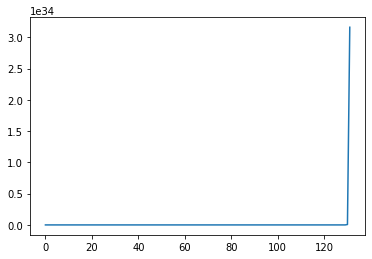

In [11]:
plt.figure()
plt.plot(ilrma.loss[1:])
plt.show()
plt.close()

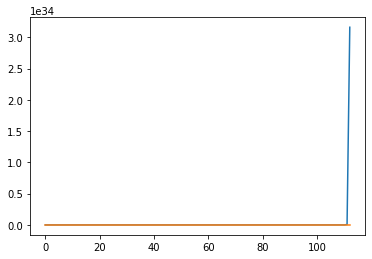

In [12]:
plt.figure()
plt.plot(ilrma.loss_diff_basis[20:])
plt.plot(ilrma.loss_diff_activation[20:])
plt.show()
plt.close()

In [13]:
np.sum(np.array(ilrma.loss_diff_basis) < 0), np.sum(np.array(ilrma.loss_diff_activation) < 0)

(0, 0)